## Pseudotemporal differential expression analysis

### Introduction

Here, we demonstrate how to perform pseudotemporal differential expression analysis using [tradeSeq](https://www.nature.com/articles/s41467-020-14766-3). We define lineage trajectories based on lineage fate probabilities. When you analyze your own data, please run the [fate probability analysis](https://github.com/TomoyaIsobe/PMCA/blob/main/3_fate_probability.ipynb) first.<br>
In this tutorial, we use our PMCA Jak2 dataset.

### Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from anndata import AnnData
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import rcParams
rcParams['figure.figsize'] = (5, 5)
import random
random.seed(123)
import warnings
warnings.filterwarnings("ignore")

### Preparing input data

Preprocessing the data to recalculate pseudotime for the entire Jak2 dataset as the pseudotime scale has to be shared by all samples.

In [2]:
# TradeSeq uses raw expression counts.
# This raw count data can be found in the "data" directory.
adata = sc.read('data/PMCA_Jak2_raw_count.h5ad')

In [3]:
adata.raw = adata.copy()

In [4]:
# Adding HSC score to metadata
hsc_score = pd.read_csv('data/PMCA_Jak2_hsc_scores.csv',index_col=0)
hsc_score.columns = ['HSC_score']
adata.obs = pd.concat([adata.obs, hsc_score], axis=1)

In [5]:
# Removing the cells without assigned cell types
adata = adata[(adata.obs['celltype']!='Unassigned'),:]

In [6]:
# Log-normalization
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

Trying to set attribute `.obs` of view, copying.


In [7]:
# Using only HVGs
hvg = np.genfromtxt('scripts/Dahlin_HVG.txt', dtype=str)
adata = adata[:,hvg]

In [8]:
sc.pp.scale(adata)

In [9]:
sc.tl.pca(adata, n_comps=50, svd_solver = 'arpack')

In [10]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50)

In [11]:
sc.tl.diffmap(adata)

### Computing diffusion pseudotime

Smoothing the HSC score

In [12]:
adata_hsc = adata[adata.obs['celltype']=='HSCs'].copy()
X_diffmap = adata_hsc.obsm['X_diffmap']

In [13]:
D_sub = euclidean_distances(X_diffmap, X_diffmap)

In [14]:
knn = D_sub
smoothed = []

for i in range(knn.shape[0]):
    tmp = np.array(knn[i])
    ind = np.argpartition(tmp, 10)[:10]
    neighbours = adata_hsc.obs.index[ind]
    
    adata_tmp = adata_hsc[neighbours,:].copy()
    
    array_tmp = np.append(adata_tmp.obs['HSC_score'], adata_hsc.obs['HSC_score'][1])
    knn_mean_tmp = array_tmp.mean()
    smoothed.append(knn_mean_tmp)

In [15]:
adata_hsc.obs['HSC_score_smoothed'] = smoothed

Defining the root cell as the cell with the highest smoothed HSC score

In [16]:
root_idx = adata_hsc.obs['HSC_score_smoothed'].idxmax()
adata.uns['iroot'] = np.flatnonzero(adata.obs.index  == root_idx)[0]

Computing diffusion pseudotime

In [17]:
sc.tl.dpt(adata)

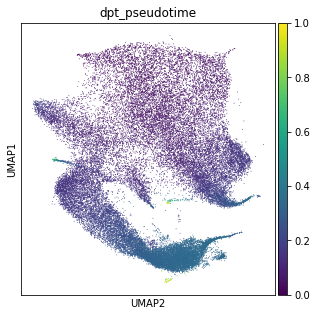

In [18]:
sc.pl.umap(adata, color='dpt_pseudotime',components=['2,1'])

### Defining lineage trajectory

In [19]:
# Precomputed fate probabilities are stored in our PMCA datasets.
# Please download the processed data from our PMCA web portal.
pmca = sc.read('data/PMCA_Jak2.h5ad')

In [20]:
pmca = pmca[adata.obs.index,:].copy()

In [21]:
adata.obs = pd.concat([adata.obs, pmca.obs[['fate_prob_Ery', 'fate_prob_Mk', 'fate_prob_Neu', 'fate_prob_Mo', 'fate_prob_Ly']]], axis=1)

In [22]:
adata.obs['Ery_trajectory'] = 'No'
adata.obs['Ery_trajectory'] = adata.obs['Ery_trajectory'].astype('str')
adata.obs['Ery_trajectory'][(adata.obs['celltype'].isin(['HSCs','Immature','MEP','Early_Ery','Middle ','Late_Ery']))&(adata.obs.fate_prob_Ery>=0.20)&(adata.obs.fate_prob_Neu<0.3)&(adata.obs.fate_prob_Mo<0.23)] = 'Yes'
adata.obs['Ery_trajectory'][adata.obs.dpt_pseudotime >=0.4] = 'No'
adata.obs['Ery_trajectory'] = adata.obs['Ery_trajectory'].astype('category')

In [23]:
adata.uns['Ery_trajectory_colors'] = ['#cccccc','#b22222']

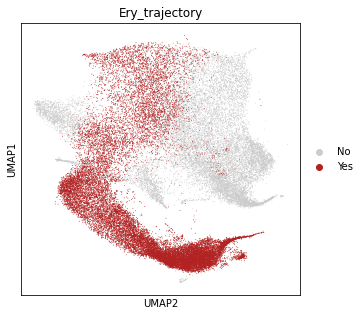

In [24]:
sc.pl.umap(adata,color='Ery_trajectory',components=['2,1'])

In [25]:
adata = adata[adata.obs.Ery_trajectory=='Yes'].copy()

### Removing low-expression genes

In [26]:
# Restoring the raw counts
adata = AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, obsm=adata.obsm)

In [27]:
adata_raw = adata.copy()

In [28]:
# Removing unexpressed genes
sc.pp.filter_genes(adata, min_cells = 1)

In [29]:
# CP10K normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [30]:
# Removing low-expression genes with CP10K ≤ 0.05
meanExp = np.mean(adata.X.todense(), axis=0)
adata = adata[:,meanExp>0.05].copy()

In [31]:
adata_raw = adata_raw[:,adata.var.index].copy()

In [32]:
# Using this file as input for the tradeSeq analysis below
adata_raw.write('data/PMCA_Jak2_Ery_raw_count.h5ad')

### Running tradeSeq analysis

This example script generates the following output files:<br>
- Fitted generalized additive model: data/PMCA_Jak2_sceGAM.rds<br>
- Table of differential expression results: data/PMCA_Jak2_pseudotemporal_DE.txt
- Expression smoothers for the 5 most significant genes: data/PMCA_Jak2_[Gene Name].pdf

All output files will be saved in the "data" directory. When you analyze your own data, please change the "params" section within the R script.

In [33]:
!R --vanilla --slave < scripts/pseudotemporal_DE.R

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, ro